## SSAC - Exploration 9 - lightgbm, xgboost, eda : kaggle

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from scipy.stats import spearmanr # spearman corr
from sklearn.model_selection import train_test_split  # 훈련, 테스트 분리
from sklearn.metrics import mean_squared_error  # mse
from xgboost import XGBRegressor  # xgboost
from lightgbm import LGBMRegressor # light gbm
from sklearn.ensemble import RandomForestRegressor  # 랜덤포레스트
from sklearn.model_selection import GridSearchCV   # 그리드 서치

### 1.1 데이터 불러오기

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = os.path.join(data_dir, 'train.csv')
test_data_path = os.path.join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
print(f'train data dim : {train.shape}')
print(f'test data dim : {test.shape}')

train data dim : (15035, 21)
test data dim : (6468, 20)


## 1.2 변수 설명   

ID : 집을 구분하는 번호   
date : 집을 구매한 날짜   
price : 집의 가격(Target variable)   
bedrooms : 침실의 수   
bathrooms : 화장실의 수   
sqft_living : 주거 공간의 평방 피트(면적)   
sqft_lot : 부지의 평방 피트(면적)   
floors : 집의 층 수   
waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)   
view : 집이 얼마나 좋아 보이는지의 정도   
condition : 집의 전반적인 상태   
grade : King County grading 시스템 기준으로 매긴 집의 등급   
sqft_above : 지하실을 제외한 평방 피트(면적)   
sqft_basement : 지하실의 평방 피트(면적)   
yr_built : 지어진 년도   
yr_renovated : 집을 재건축한 년도   
zipcode : 우편번호   
lat : 위도   
long : 경도   
sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)   
sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)   

In [3]:
display(train.head(2))
display(train.tail(2))

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.0,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.0,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15033,15033,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
15034,15034,20141015T000000,325000.0,2,0.75,1020,1076,2.0,0,0,...,7,1020,0,2008,0,98144,47.5941,-122.299,1020,1357


In [4]:
display(test.head(2))
display(test.tail(2))

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
6466,21501,20140623T000000,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
6467,21502,20150116T000000,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [5]:
test.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

관련 없는 변수 :   id   

일자 : date   

독립변수   
+ 연속형 변수 : sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15   
+ 범주형 변수 : bedrooms, bathrooms, floors, waterfront, view, condition, grade, yr_built, yr_renovated, zipcode, lat, long    
   
목적변수(target) :  price   

### 1.3 결측치 확인

<AxesSubplot:>

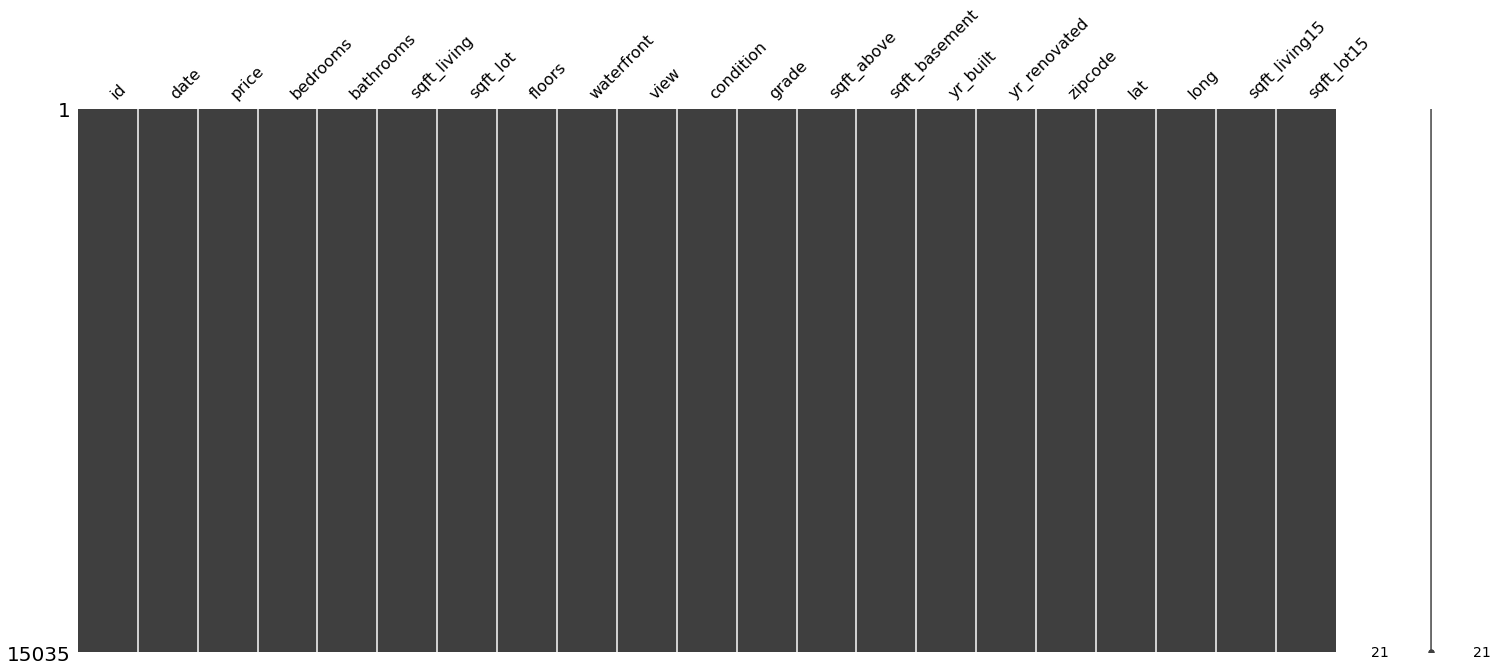

In [6]:
msno.matrix(train)

In [7]:
train.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

<AxesSubplot:>

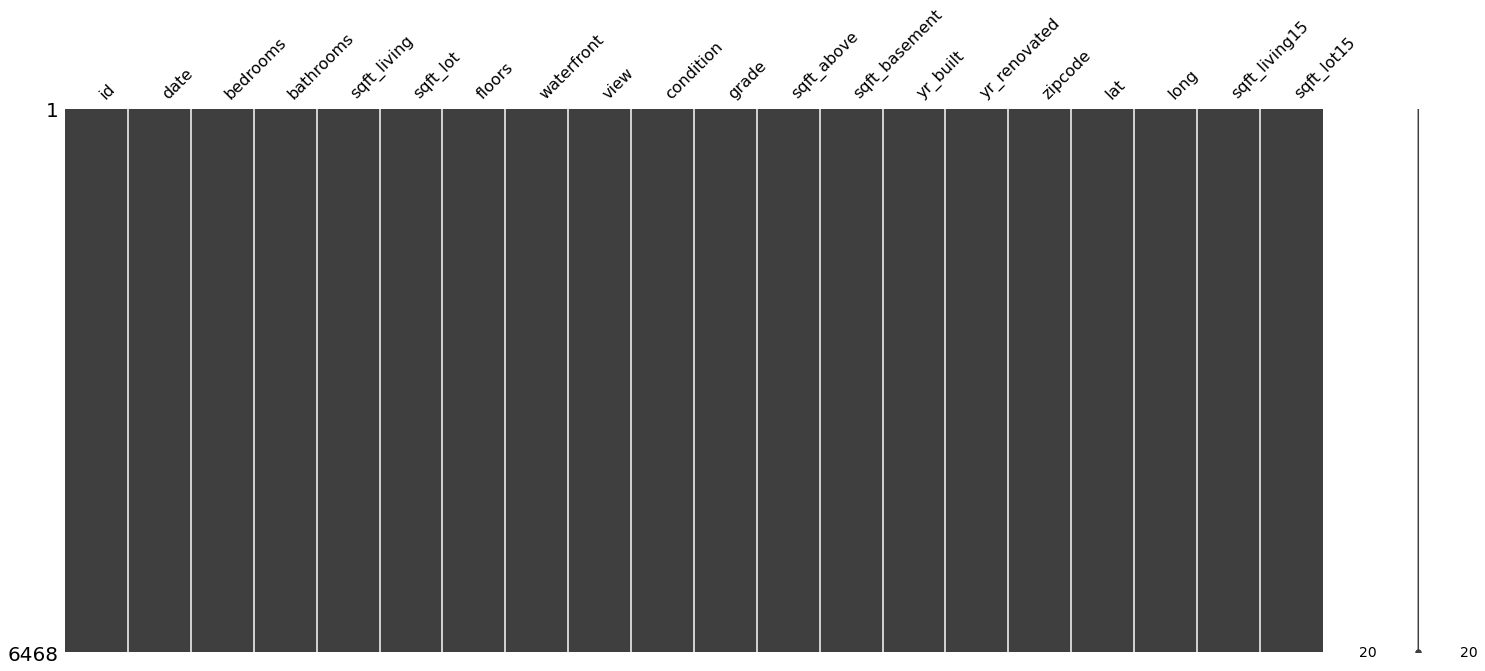

In [8]:
msno.matrix(test)

In [9]:
test.isna().sum()

id               0
date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

+ test, train 모두 결측치 없음

### 1.4 id, date 변수 정리

In [10]:
del train['id']
del test['id']
train['date'] = train['date'].apply(lambda x : str(x[:6])).astype(str)

### 1.5 데이터 분포 확인

In [11]:
train.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

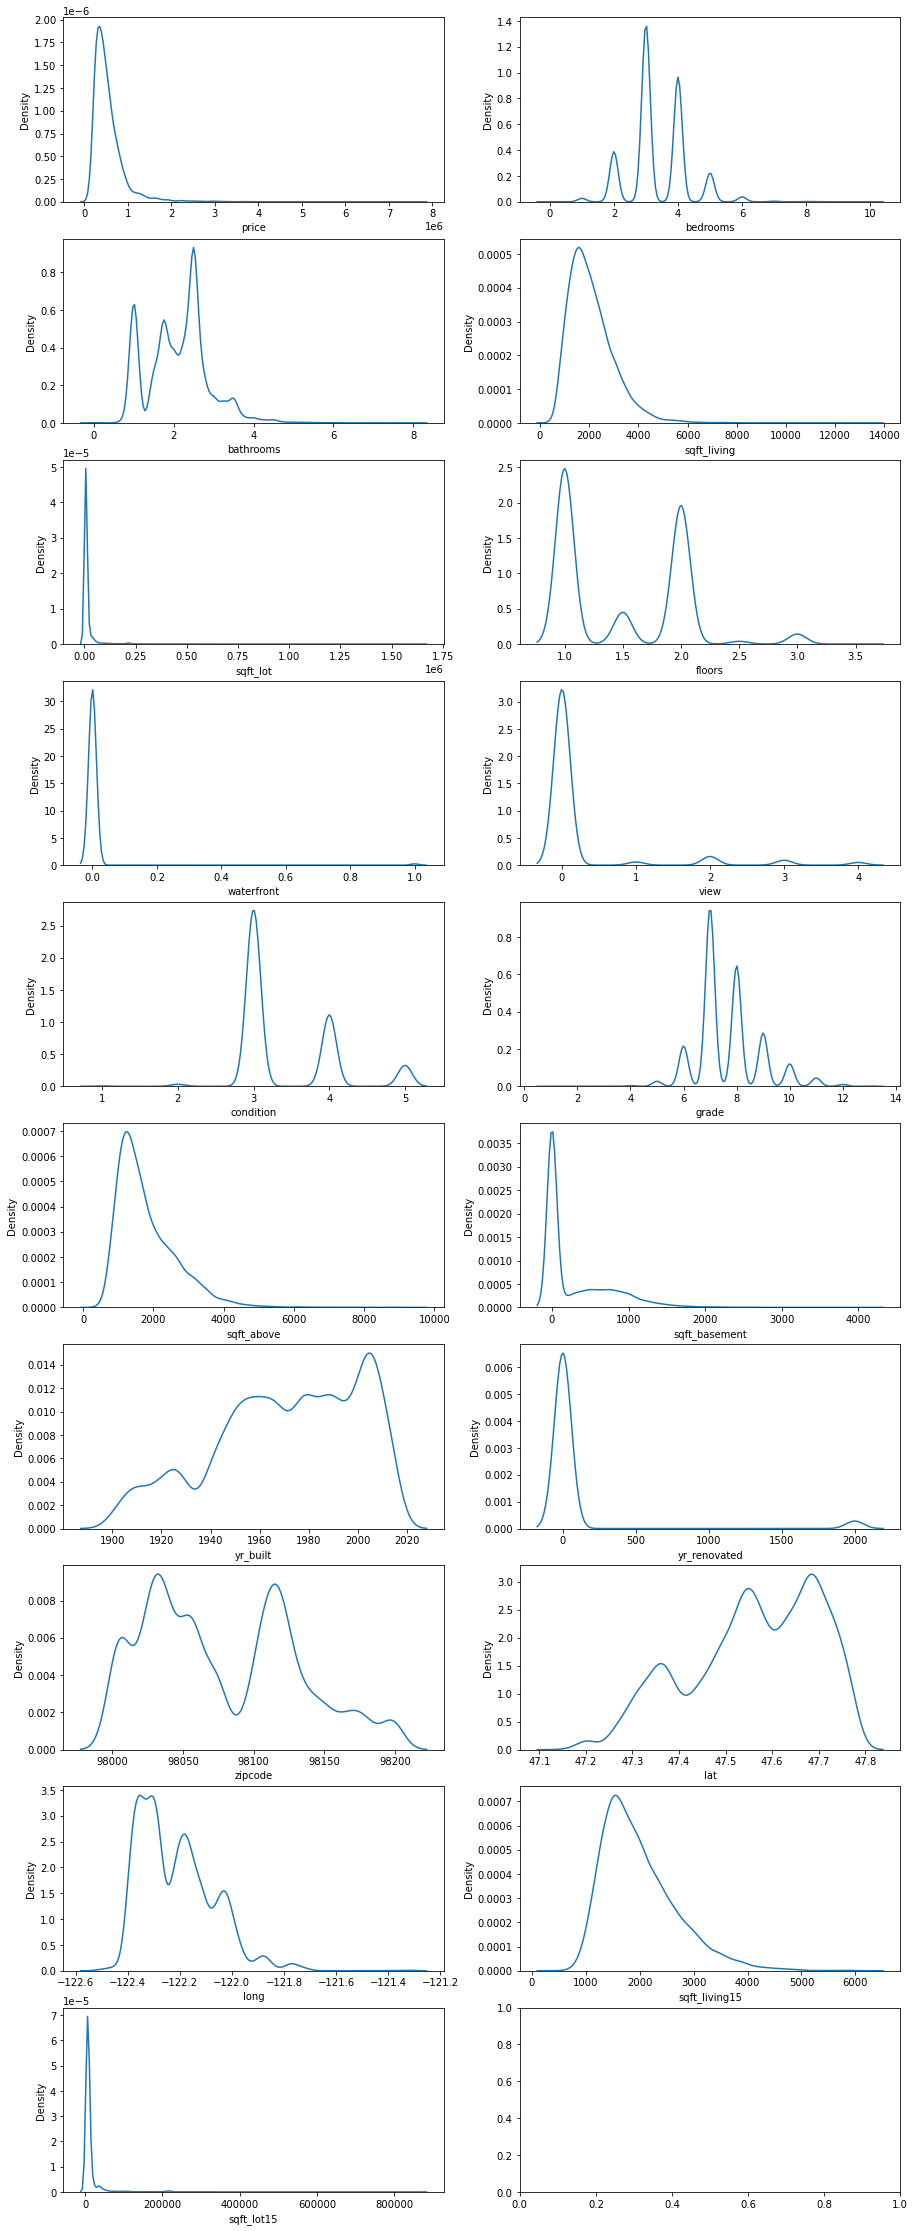

In [12]:
fig, ax = plt.subplots(10, 2, figsize=(15, 40))

count = 0
columns = train.columns[1:]
for row in range(10):
    for col in range(2):
        sns.kdeplot(train[columns[count]], ax=ax[row][col])
        count+=1
        if count == 19 :
            break

연속형 변수 중 price, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보이니 조정해 주기로 한다.

In [13]:
skewed_cols = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skewed_cols:
    train[c] = np.log1p(train[c].values)
    test[c] = np.log1p(test[c].values)

train['price'] = np.log1p(train['price'].values)

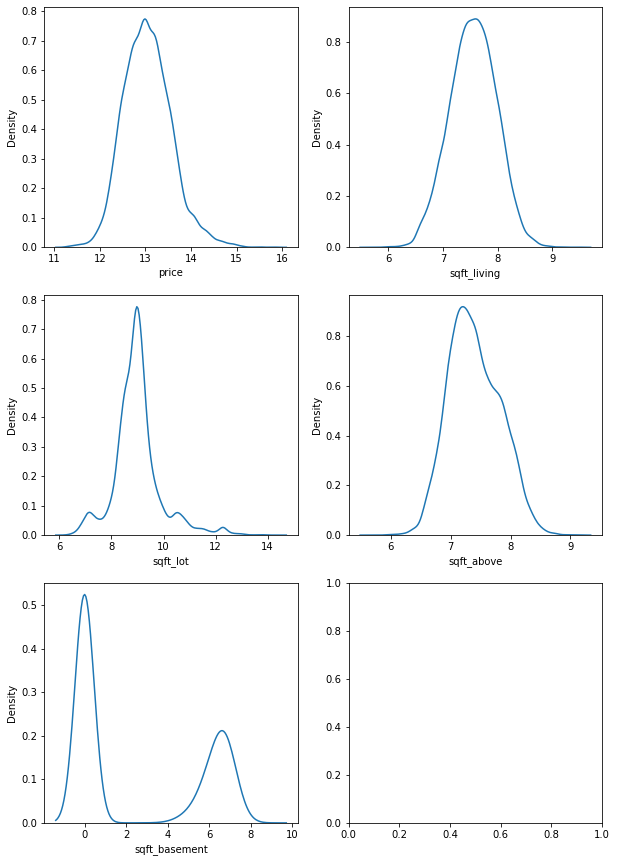

In [14]:
skewed_cols = ['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(train[skewed_cols[count]], ax=ax[row][col])
        count+=1

### 1.6 도시 변수 추가

In [15]:
from uszipcode import SearchEngine
search = SearchEngine(simple_zipcode=True)

In [16]:
search.by_zipcode(train.zipcode[0]).values()[2]

'Seattle'

In [17]:
def get_city_with_zipcode(zip_code):
    city = search.by_zipcode(zip_code).values()[2]
    return city

In [18]:
test['city'] = test['zipcode'].apply(get_city_with_zipcode)

In [19]:
test.city.unique()

array(['Seattle', 'Redmond', 'Maple Valley', 'Auburn', 'Sammamish',
       'Renton', 'Duvall', 'Vashon', 'Bellevue', 'Mercer Island',
       'Kirkland', 'Snoqualmie', 'Issaquah', 'Kent', 'Federal Way',
       'Enumclaw', 'North Bend', 'Woodinville', 'Fall City', 'Carnation',
       'Kenmore', 'Bothell', 'Black Diamond', 'Medina'], dtype=object)